In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Exploring A Model
============================

This tutorial discusses using the phase_plane_interactive plotting tool to explore
the dynamics of a Model object and, at the same time, set its parameters.

This works best for the simpler, 2d, Models, as their trajectories and nullclines
lie within a single plane and are thus easily visualised. And so, for the demo here 
we'll stick with a Model of that type. However, although it requires a little more 
effort, it can still be used to get a basic handle on the dynamics of higher 
dimensional models.

It is also important to note that this is only for the local dynamic model, that is,
it only represents the dynamic behaviour of a disconnected node. 

Setup
-----

We'll start in our usual way, by importing everything from the "lab", to get
a basic working environment. 

In [2]:
from tvb.simulator.lab import *

In its current form the "lab" doesn't import the "phase_plane_interactive" plotting tool 
and so we need to import it explicitly

In [3]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

Create An Interactive Phase-Plane
----------------------------------

PhasePlaneInteractive produces an interactive window containing plots of a Model's
phase-plane, sample trajectories, and sliders and buttons for adjusting various 
parameters.

The important thing to note here is that as we drag around the sliders for the Model's
parameters we are actually modifying the parameters of the Model we passed in, so when
we close the figure at the end whatever values the Model's parameters are set to will
be the values in the Model. Also, changing the range of the phase-plane plot (that is,
the extent of the x and y axis) changes the "state_variable_range" attribute of a Model.
This attribute is used when constructing random initial conditions for a simulation, so
setting the axis to be relatively tightly bound around a fixed point for example will
produce initial conditions that better approximate the range of the Model's state 
variables for the given parameters. 

We'll begin by creating a Model object and taking a quick look at its parameters:

In [4]:
#Create a specific Model object
oscillator = models.Generic2dOscillator()

#Take quick look at the initial state of our Model
repr(oscillator)

"Generic2dOscillator(a=[-2.], tau=[ 1.], c=[ 0.], noise=Noise(ntau, random_stream), e=[ 3.], d=[ 0.02], g=[ 0.], f=[ 1.], I=[ 0.], state_variable_range={'W': array([-6.,  6.]), 'V': array([-2.,  4.])}, beta=[ 1.], b=[-10.], variables_of_interest=['V'], alpha=[ 1.], gamma=[ 1.])"

We'll now create and launch the interactive plot.

**NOTE:** *Changing the Model's parameters or the axis settings causes a redraw of the entire 
phase-plane, clearing trajectories and their corresponding time-series.*

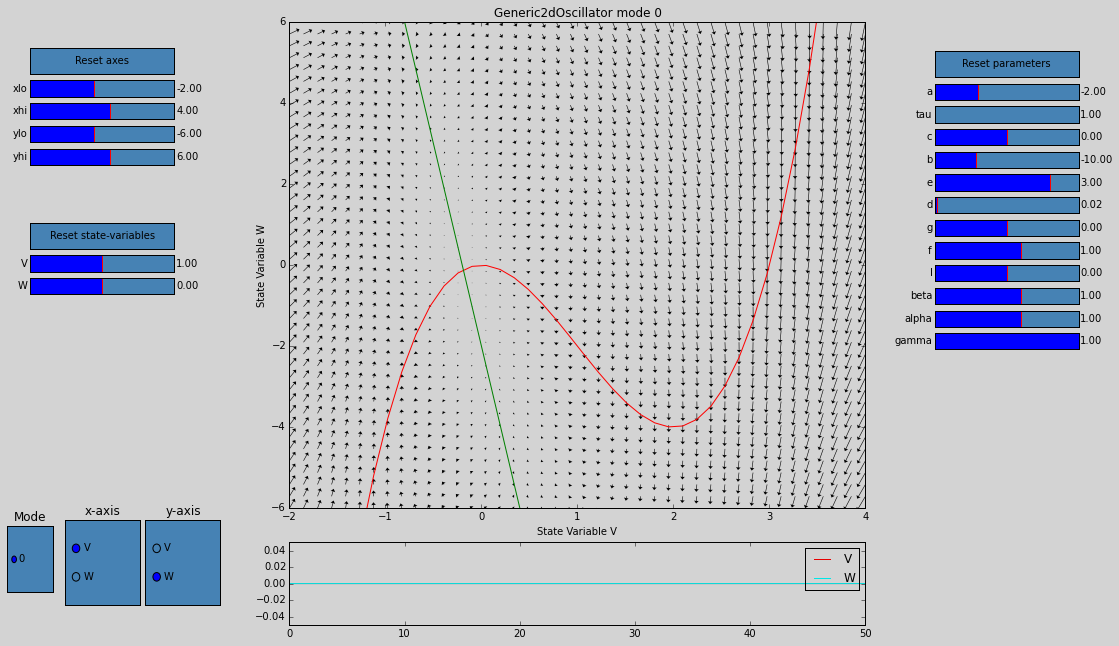

In [5]:
#Create and launch an interactive phase plane plot
ppi_fig = PhasePlaneInteractive(model=oscillator)
ppi_fig.show()

In the main central panel of the window you can see the phase-plane for the model, including arrows
representing the vector field and coloured lines representing any nullclines present in this plane.
Clicking on the phase-plane will launch a sample trajectory originating from where you clicked. 
Below the phase-plane is a panel which will show time-series for all state variables for any sample 
trajectories you initiate. All around the edges are sliders for adjusting Model parameters and 
adjusting what is displayed. The red vertical lines in sliders indicate the initial values. 

After we've adjusted parameters to our satisfaction we can close the window and take another
quick look at the parameters of our Model

In [6]:
#Take another quick look at the state of our Model
repr(oscillator)

"Generic2dOscillator(a=[-2.], tau=[ 1.], c=[ 0.], noise=Noise(ntau, random_stream), e=[ 3.], d=[ 0.02], g=[ 0.], f=[ 1.], I=[ 0.], state_variable_range={'W': array([-6.,  6.]), 'V': array([-2.,  4.])}, beta=[ 1.], b=[-10.], variables_of_interest=['V'], alpha=[ 1.], gamma=[ 1.])"

As you can see in the line above, the Model's parameters, for example "a", "tau", and the
state_variable_ranges are modified from their initial values.

Specifying Stochastic Integration
----------------------------------

It is possible to explicitly specify the integration scheme used to plot sample 
trajectories. This can be useful when deciding what amplitude to give your noise 
when specifying a stochastic integration scheme.

We'll take a look at this using HeunStochastic, we'll also pass in the same Model
object we modified above. In this way PhasePlaneInteractive initialises with the 
parameters we'd set for the Model, so that here we can focus on the effect of 
the noise amplitude relative to the intrinsic dynamics.

Unlike changes to Model parameters and the axes, changing to the noise 
amplitude doesn't cause a redraw of the existing trajectories, so, after creating 
a trajectory you can alter the noise strength and click on the same starting 
location to see the effect of a different noise amplitude on the same trajectory.

Starting by setting the noise to 0.0, to get a deterministic trajectory, and then
adding a small amount of noise can help give a useful intuition for the effects of
noise on a simulation.

Also, as the random sequence used each time you launch a trajectory is distinct, 
clicking on the same point multiple times will give you an idea of the range 
of trajectory a given type of noise can produce.

Alternatively, clicking reset random stream enables you to see the effect of 
the same random sequence with different amplitudes or on a trajectory initiating
from a different location.

**Note:** *The default standard deviation for the noise is 1.0, which is too large 
(in the sense that noise will dominate the intrinsic dynamics) relative to the range
of our Model's state variables.*

In [7]:
heunstochint = integrators.HeunStochastic(dt=2**-5)

#Take quick look at the initial state of our Integrator
repr(heunstochint.noise)

'Additive(ntau=0.0, random_stream=<mtrand.RandomState object at 0x7f93bc8b5f90>, nsig=[ 1.])'

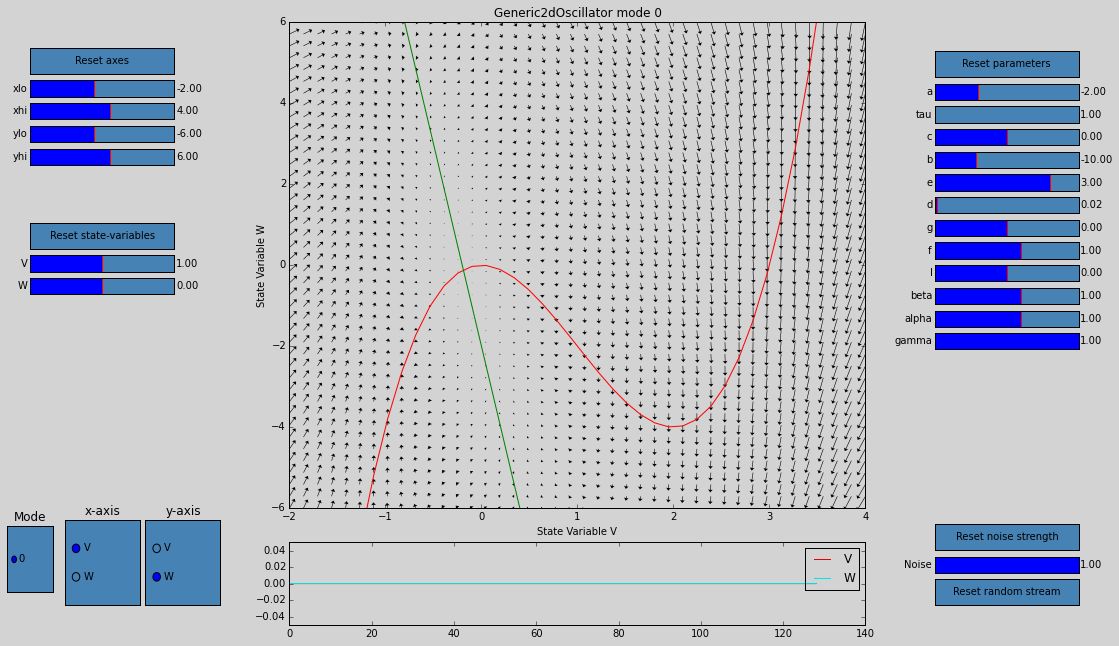

In [8]:
#Create and launch an interactive phase plane plot
ppi_fig = PhasePlaneInteractive(model=oscillator, integrator=heunstochint)
ppi_fig.show()

In [9]:
repr(heunstochint.noise)

'Additive(ntau=0.0, random_stream=<mtrand.RandomState object at 0x7f93bc8b5f90>, nsig=[ 1.])'

Simulate and Visualise
-----------------------

Finally, we can use the objects that we've graphically set above in a simulation 

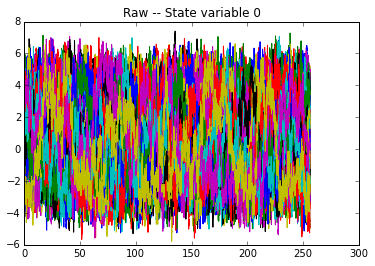

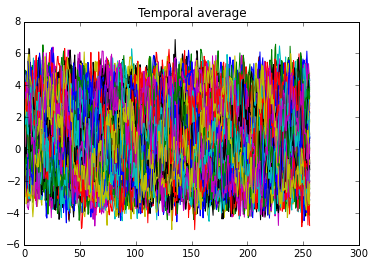

In [11]:
#Connectivity and Coupling
white_matter = connectivity.Connectivity(load_default=True)
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Linear(a=0.0152)

#Initialise some Monitors with period in physical time
mon_raw = monitors.Raw()
mon_tav = monitors.TemporalAverage(period=2**-1)
#Bundle them
what_to_watch = (mon_raw, mon_tav)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model = oscillator, 
                          connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunstochint, 
                          monitors = what_to_watch)

sim.configure()

#Perform the simulation
raw_data = []
raw_time = []
tavg_data = []
tavg_time = []
for raw, tavg in sim(simulation_length=2**8):
    if not raw is None:
        raw_time.append(raw[0])
        raw_data.append(raw[1])
    
    if not tavg is None:
        tavg_time.append(tavg[0])
        tavg_data.append(tavg[1])

#Make the lists numpy.arrays for easier use.
RAW = numpy.array(raw_data)
TAVG = numpy.array(tavg_data)

#Plot raw time series
figure(1)
plot(raw_time, RAW[:, 0, :, 0])
title("Raw -- State variable 0")

#Plot temporally averaged time series
figure(2)
plot(tavg_time, TAVG[:, 0, :, 0])
title("Temporal average")

That's All Folks... so what now?
--------------------------------